In [1]:
import torch
import os

os.chdir('../')

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from itertools import chain
from rdkit.Chem import Descriptors
from src.tacogfn.utils import misc, molecules, sascore

Get generated results

In [3]:
ref_fps = misc.get_reference_fps()

In [23]:
pocket2mol_res = torch.load('misc/benchmarking/pocket2mol_res.pt')
targetdiff_res = torch.load('misc/benchmarking/targetdiff_res.pt')

In [10]:
pharmaco_res_path = 'misc/evaluations/20240117_alpha_default_evaluated.json'
with open(pharmaco_res_path) as f:
    pharmaco_res = json.load(f)

Compute diversity

In [31]:
def compute_metrics(res):
    benchmark_eval = {}

    for pocket, val in tqdm(res.items()):
        smiles = val["smiles"]

        mols = [Chem.MolFromSmiles(smi) for smi in smiles]
        n_nones = len([mol for mol in mols if mol is None])
        if n_nones > 0:
            print(f"{n_nones} molecules could not be parsed")
        
        mols = [mol for mol in mols if mol is not None]
        
        

        qeds = [Descriptors.qed(mol) for mol in mols]
        sas = [(10.0 - sascore.calculateScore(mol)) / 9 for mol in mols]
        diversity = molecules.compute_diversity(mols)
        novelty = molecules.compute_novelty(mols, ref_fps)

        benchmark_eval[pocket] = {
            "smiles": smiles,
            "qeds": qeds,
            "sas": sas,
            "diversity": diversity,
            "novelty": novelty,
        }
    return benchmark_eval

In [32]:
pocket2mol_eval = compute_metrics(pocket2mol_res)

100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


In [33]:
targetdiff_eval = compute_metrics(targetdiff_res)

  5%|▌         | 5/100 [00:01<00:27,  3.42it/s][17:36:01] Explicit valence for atom # 2 N, 4, is greater than permitted


1 molecules could not be parsed


 15%|█▌        | 15/100 [00:04<00:25,  3.28it/s][17:36:05] Explicit valence for atom # 13 N, 4, is greater than permitted


1 molecules could not be parsed


 49%|████▉     | 49/100 [00:15<00:13,  3.78it/s][17:36:15] Explicit valence for atom # 6 N, 4, is greater than permitted


1 molecules could not be parsed


 58%|█████▊    | 58/100 [00:18<00:13,  3.19it/s][17:36:18] Explicit valence for atom # 19 N, 4, is greater than permitted


1 molecules could not be parsed


 70%|███████   | 70/100 [00:21<00:07,  3.88it/s][17:36:21] Explicit valence for atom # 6 N, 4, is greater than permitted


1 molecules could not be parsed


 73%|███████▎  | 73/100 [00:22<00:08,  3.32it/s][17:36:22] Explicit valence for atom # 6 N, 4, is greater than permitted


1 molecules could not be parsed


 81%|████████  | 81/100 [00:25<00:06,  2.86it/s][17:36:25] Explicit valence for atom # 21 N, 4, is greater than permitted


1 molecules could not be parsed


 82%|████████▏ | 82/100 [00:25<00:06,  2.78it/s][17:36:25] Explicit valence for atom # 8 N, 4, is greater than permitted


1 molecules could not be parsed


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


In [34]:
compute_novelty = lambda metrics : list(chain.from_iterable([v["novelty"] for k, v in metrics.items()]))
compute_diversity = lambda metrics : list(chain.from_iterable([v["diversity"] for k, v in metrics.items()]))

In [38]:
pocket2mol_novelty = compute_novelty(pocket2mol_eval)
targetdiff_novelty = compute_novelty(targetdiff_eval)
pharmacogfn_novelty = compute_novelty(pharmaco_res)

print(f"Pocket2Mol Novelty: {np.mean(pocket2mol_novelty), np.median(pocket2mol_novelty)}")
print(f"TargetDiff Novelty: {np.mean(targetdiff_novelty), np.median(targetdiff_novelty)}")
print(f"PharmacoGFN Novelty: {np.mean(pharmacogfn_novelty), np.median(pharmacogfn_novelty)}")

Pocket2Mol Novelty: (0.45523859771851155, 0.4812707098835389)
TargetDiff Novelty: (0.4872655609643206, 0.4983498349834984)
PharmacoGFN Novelty: (0.6942025859700549, 0.6964285714285714)


In [39]:
pharmacogfn_diversity = compute_diversity(pharmaco_res)
print(f"PharmacoGFN Diversity: {np.mean(pharmacogfn_diversity), np.median(pharmacogfn_diversity)}")

PharmacoGFN Diversity: (0.7344087070450731, 0.7397260273972603)


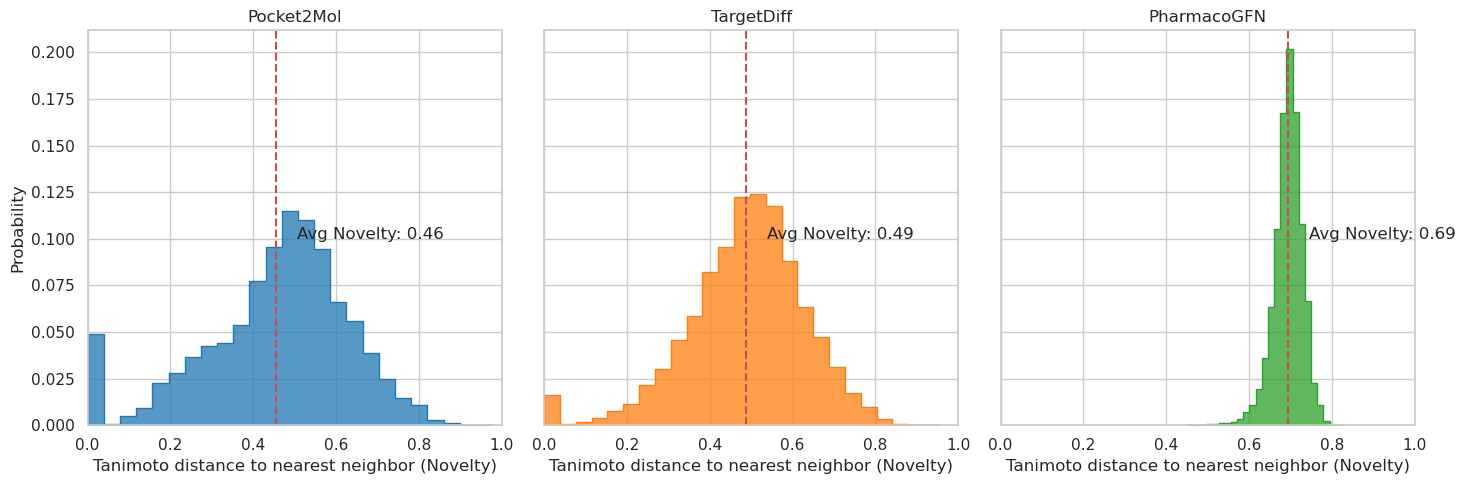

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# create a dictionary to map categories to labels
category_labels = {'Pocket2Mol': 'Pocket2Mol', 'PharmacoGFN': 'PharmacoGFN', 'TargetDiff': 'TargetDiff'}

data = pd.DataFrame({
    'Method': ['Pocket2Mol'] * len(pocket2mol_novelty) + ['TargetDiff'] * len(targetdiff_novelty) + ['PharmacoGFN'] * len(pharmacogfn_novelty),
    'Novelty': pocket2mol_novelty + targetdiff_novelty + pharmacogfn_novelty,
})

sns.set_theme(style="whitegrid")

# Define a custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, method in enumerate(['Pocket2Mol', 'TargetDiff', 'PharmacoGFN']):
    ax = axes[i]
    method_data = data[data['Method'] == method]
    ax = sns.histplot(x="Novelty", data=method_data, stat='probability', ax=ax, bins=25, color=custom_palette[i], element='step')
    ax.set_xlabel('Tanimoto distance to nearest neighbor (Novelty)')
    ax.set_ylabel('Probability')
    ax.set_title(method)
    ax.set_xlim(0, 1)
    
    # Calculate the mean value for the method
    mean_value = method_data['Novelty'].mean()
    
    # Draw vertical line at the mean value and write the mean value on the plot
    ax.axvline(mean_value, color='r', linestyle='--', label=f'Mean ({method})')
    ax.annotate(f'Avg Novelty: {mean_value:.2f}', xy=(mean_value, 0.1), xytext=(mean_value + 0.05, 0.1))

plt.tight_layout()
plt.show()


In [13]:
import seaborn as sns

# create a dictionary to map categories to labels
category_labels = {'Benchmark': 'Benchmark', 'Pharmaco': 'Pharmaco'}

data = pd.DataFrame({
    'Method': ['Pocket2Mol'] * len(benchmark_diversity) + ['PharmacoGFN'] * len(pharmaco_diversity),
    'Diversity': benchmark_diversity + pharmaco_diversity,
})

PharmacoGFN mean: 0.73
Pocket2Mol mean: 0.75


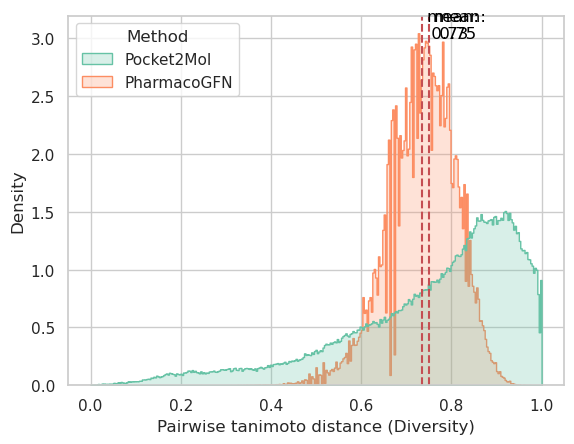

In [14]:
sns.set_theme(style="whitegrid")

ax = sns.histplot(x="Diversity", hue="Method", data=data, palette="Set2", element="step", stat='density')
ax.set_xlabel('Pairwise tanimoto distance (Diversity)')
ax.set_ylabel('Density')

# Calculate the mean values for each group
mean_values = data.groupby('Method')['Diversity'].mean()

# Draw vertical lines at the mean values and write the mean value on the plot
for method, mean in mean_values.items():
    ax.axvline(mean, color='r', linestyle='--', label=f'Mean ({method})')
    ax.annotate(f'mean:\n {mean:.2f}', xy=(mean, 0.5), xytext=(mean + 0.01, 3), color='black')
    print(f'{method} mean: {mean:.2f}')


In [16]:
# np.mean(all_vals['novelty'])

In [17]:
# all_vals['novelty'].index(np.min(all_vals['novelty']))

In [18]:
from fcd import get_fcd, load_ref_model,canonical_smiles, get_predictions, calculate_frechet_distance

model = load_ref_model()

In [19]:
crossdock = torch.load("dataset/crossdock_docking_scores/all_crossdock_100k.pt")
crossdock_smiles = list(set([v[1] for v in crossdock]))

In [20]:
from rdkit import Chem

benchmark_smis = list(chain.from_iterable([v['smiles'] for _, v in benchmark_res.items()]))
benchmark_mols = [Chem.MolFromSmiles(s) for s in benchmark_smis]

In [21]:
p_smi = list(chain.from_iterable([v['smiles'] for _, v in pharmaco_res.items()]))
p_mols = [Chem.MolFromSmiles(m) for m in p_smi]
p_fps = np.array([list(Chem.RDKFingerprint(m)) for m in p_mols])

In [22]:
act0 = get_predictions(model, crossdock_smiles)
act1 = get_predictions(model, benchmark_smis)
act2 = get_predictions(model, p_smi)

In [23]:
pocket2mol_fps = np.array([list(Chem.RDKFingerprint(m)) for m in benchmark_mols])

In [24]:
ref_fps = np.array([list(k) for k in ref_fps])

In [25]:
# import umap

# reducer = umap.UMAP(n_components=2)
from sklearn import manifold

reducer = manifold.TSNE(n_components=2, random_state=0)

In [26]:
features = reducer.fit_transform(np.vstack([act0, act1, act2]))

# features = reducer.fit_transform(np.vstack([p_fps, pocket2mol_fps, ref_fps]))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f764b9fc9d0>
Traceback (most recent call last):
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [27]:
# gen_features = reducer.transform()

In [28]:
# gen_features.shape

In [29]:
# p_features = reducer.transform(act2)

In [30]:
# all_features = np.concatenate([features, gen_features, p_features])

<Axes: >

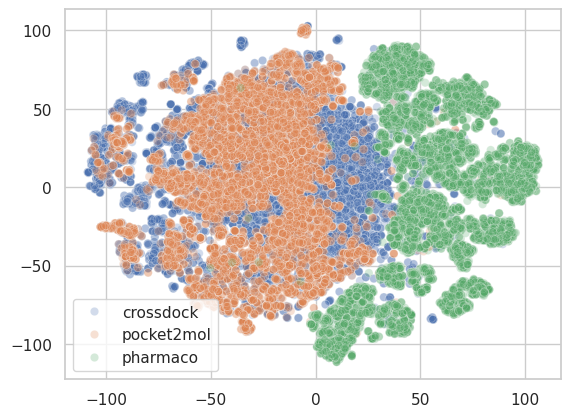

In [31]:
# scatter plot of the 2-dimensional features with seaborn

import seaborn as sns
# name each scatter plot its source 

sns.scatterplot(x=features[:,0], y=features[:,1], hue=['crossdock']*len(act0) + ['pocket2mol']*len(act1) + ['pharmaco']*len(act2), alpha=0.25)


In [32]:
len(evaluated_results[11]['smiles'])

NameError: name 'evaluated_results' is not defined

In [13]:
import numpy as np
dock = False

all_vals = {
    'qeds': [],
    'sas': [],
    'diversity': [],
    'novelty': [],
}
if dock:
    all_vals['docking_scores'] = []


for key, val in benchmark_eval.items():
    all_vals['qeds'].append(np.mean(val['qeds']))
    all_vals['sas'].append(np.mean(val['sas']))
    all_vals['diversity'].append(np.mean(val['diversity']))
    all_vals['novelty'].append(np.mean(val['novelty']))
    if dock:
        all_vals['docking_scores'].extend([v for v in val['docking_scores'] if v < 0])

In [14]:
import numpy as np
for key, val in all_vals.items():
    print(key, np.mean(val), np.median(val))

qeds 0.5643521763341997 0.5754560084755495
sas 0.7506811622943664 0.7595498695643985
diversity 0.7423542547925785 0.7748222413765954
novelty 0.4509861315074474 0.4639609831490686


(8.47, 6.0)